In [1]:
import pyrost as rst
import pyrost.simulation as st_sim
import numpy as np
import matplotlib.pyplot as plt

# Speckle tracking reconstruction of a 2d dataset

In [2]:
!wget -P results/exp "https://www.cxidb.org/data/134/diatom.cxi"

--2022-02-24 15:38:14--  https://www.cxidb.org/data/134/diatom.cxi
Resolving www.cxidb.org (www.cxidb.org)... 104.21.9.67, 172.67.159.52, 2606:4700:3033::6815:943, ...
Connecting to www.cxidb.org (www.cxidb.org)|104.21.9.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97269404 (93M) [application/octet-stream]
Saving to: ‘results/exp/diatom.cxi.1’

 9% [==>                                    ] 8,838,911   --.-K/s  eta 10m 0s  ^C


In [3]:
!h5ls -r results/exp/diatom.cxi

/                        Group
/entry_1                 Group
/entry_1/data_1          Group
/entry_1/data_1/data     Dataset {121, 516, 1556}
/entry_1/data_1/experiment_identifier Dataset {121}
/entry_1/end_time        Dataset {SCALAR}
/entry_1/experiment_identifier Dataset, same as /entry_1/data_1/experiment_identifier
/entry_1/instrument_1    Group
/entry_1/instrument_1/detector_1 Group
/entry_1/instrument_1/detector_1/basis_vectors Dataset {121, 2, 3}
/entry_1/instrument_1/detector_1/corner_positions Dataset {121, 3}
/entry_1/instrument_1/detector_1/count_time Dataset {121, 1}
/entry_1/instrument_1/detector_1/data Dataset, same as /entry_1/data_1/data
/entry_1/instrument_1/detector_1/distance Dataset {SCALAR}
/entry_1/instrument_1/detector_1/experiment_identifier Dataset, same as /entry_1/data_1/experiment_identifier
/entry_1/instrument_1/detector_1/mask Dataset {516, 1556}
/entry_1/instrument_1/detector_1/name Dataset {SCALAR}
/entry_1/instrument_1/detector_1/x_pixel_size Dataset 

In [4]:
protocol = rst.CXIProtocol.import_default()

In [5]:
inp_file = rst.CXIStore('results/exp/diatom.cxi', protocol=protocol)

mask is not loaded: Dataset at results/exp/diatom.cxi: /entry_1/instrument_1/detector_1/mask has invalid shape: (516, 1556)


In [6]:
out_file = rst.CXIStore('results/exp/diatom_proc.cxi', mode='a',
                        protocol=protocol)

In [10]:
data = rst.STData(input_file=inp_file, output_file=out_file)

In [11]:
inp_file.keys()

dict_keys(['basis_vectors', 'data', 'distance', 'translations', 'wavelength', 'x_pixel_size', 'y_pixel_size'])

In [12]:
data = data.load(processes=4)

mask is not loaded: Dataset at results/exp/diatom.cxi: /entry_1/instrument_1/detector_1/mask has invalid shape: (516, 1556)


Loading data:   0%|          | 0/121 [00:00<?, ?it/s]

In [13]:
crop = rst.Crop(roi=[80, 420, 60, 450])
data = data.update_transform(transform=crop)

In [14]:
data = data.update_mask(method='range-bad', vmax=2e3)
data = data.mask_frames(good_frames=np.arange(1, 121))

In [15]:
defoci = np.linspace(2e-3, 3e-3, 50)
sweep_scan = data.defocus_sweep(defoci, size=5, hval=1.5)
defocus = defoci[np.argmax(sweep_scan)]
print(defocus)

Generating defocus sweep:   0%|          | 0/50 [00:00<?, ?it/s]

0.002204081632653061


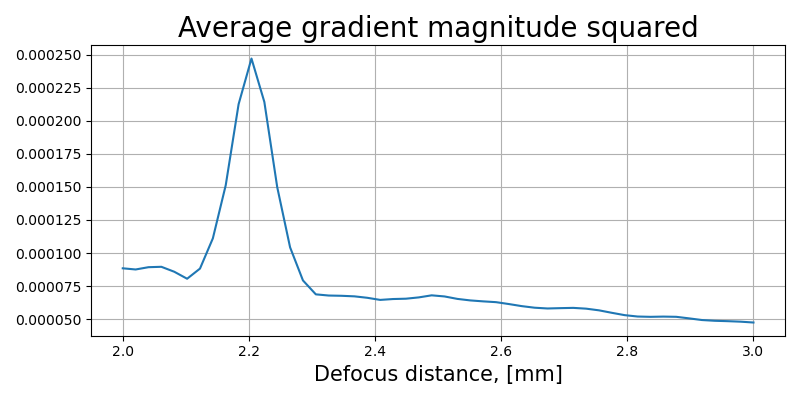

In [16]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(defoci * 1e3, sweep_scan)
ax.set_xlabel('Defocus distance, [mm]', fontsize=15)
ax.set_title('Average gradient magnitude squared', fontsize=20)
ax.grid(True)
ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/sweep_scan.png', dpi=300)

In [17]:
data = data.update_defocus(defocus)

In [18]:
st_obj = data.get_st(ds_x=1.0, ds_y=1.0)

In [19]:
h_vals = np.linspace(0.5, 3.0, 25)
cv_vals = st_obj.CV_curve(h_vals)

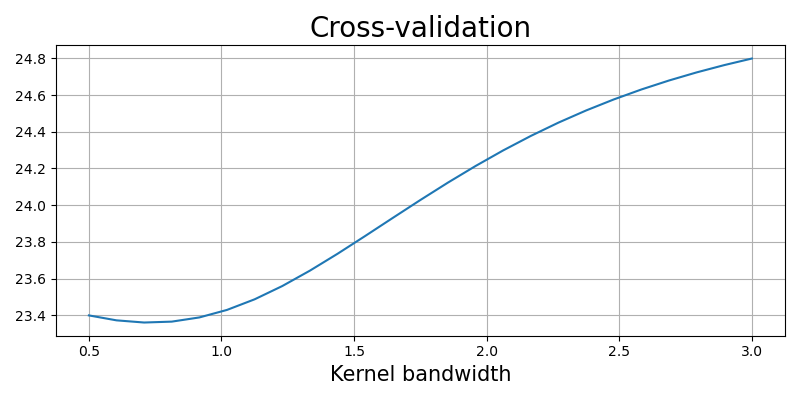

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(h_vals, cv_vals)
ax.set_xlabel('Kernel bandwidth', fontsize=15)
ax.set_title('Cross-validation', fontsize=20)
ax.tick_params(labelsize=10)
ax.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/cv_curve.png', dpi=300)

In [21]:
st_obj = data.get_st(ds_x=1.0, ds_y=1.0)
st_obj = st_obj.create_initial()
h0 = st_obj.find_hopt(verbose=True)
print(h0)

   0%            Iteration 0 / 10 [00:00<?, ?it/s]

0.7500000134551241


In [30]:
st_res = st_obj.train_adapt(search_window=(5.0, 5.0, 0.1), h0=h0, blur=8.0, n_iter=10,
                            pm_method='rsearch', pm_args={'n_trials': 50}, options={'momentum': 0.3})

   0%            Iteration 0 / 10 [00:00<?, ?it/s]

Initial error = 0.909600, Initial h0 = 0.75


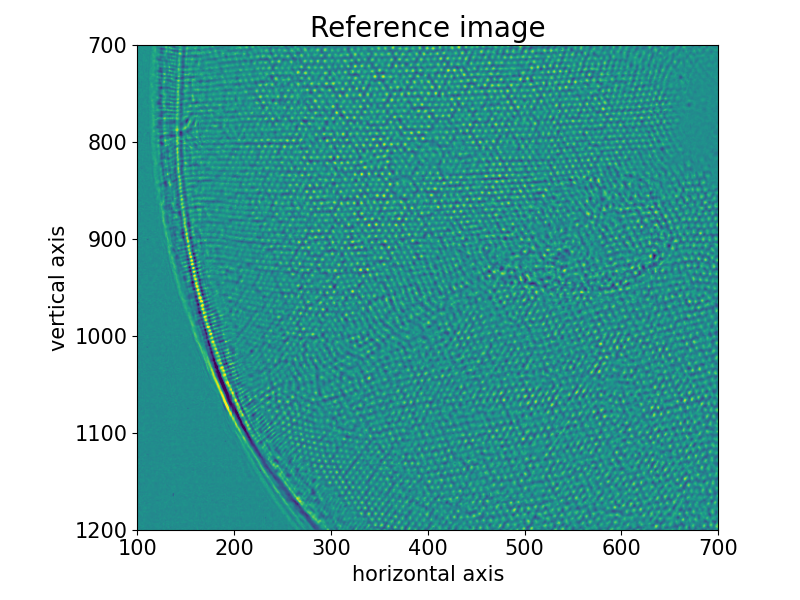

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(st_res.reference_image[700:1200, 100:700], vmin=0.7, vmax=1.3,
          extent=[100, 700, 1200, 700])
ax.set_title('Reference image', fontsize=20)
ax.set_xlabel('horizontal axis', fontsize=15)
ax.set_ylabel('vertical axis', fontsize=15)
ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/diatom_image.png', dpi=150)

In [32]:
data.import_st(st_res)
fit_obj_ss = data.get_fit(axis=0)
fit_ss = fit_obj_ss.fit(max_order=3)
fit_obj_fs = data.get_fit(axis=1)
fit_fs = fit_obj_fs.fit(max_order=3)

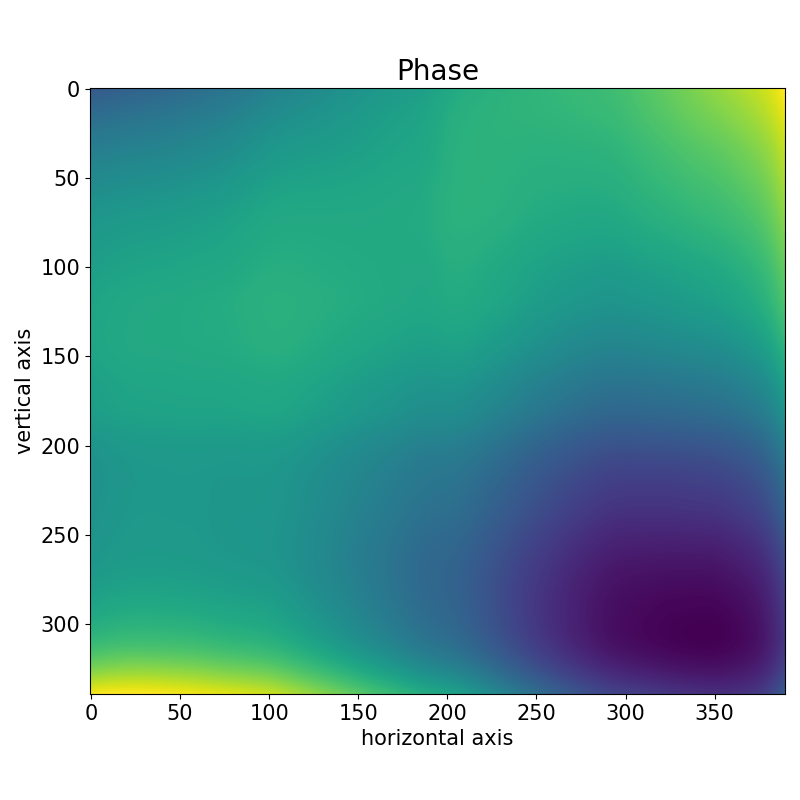

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(data.get('phase'))
ax.set_title('Phase', fontsize=20)
ax.set_xlabel('horizontal axis', fontsize=15)
ax.set_ylabel('vertical axis', fontsize=15)
ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/diatom_phase.png', dpi=150)

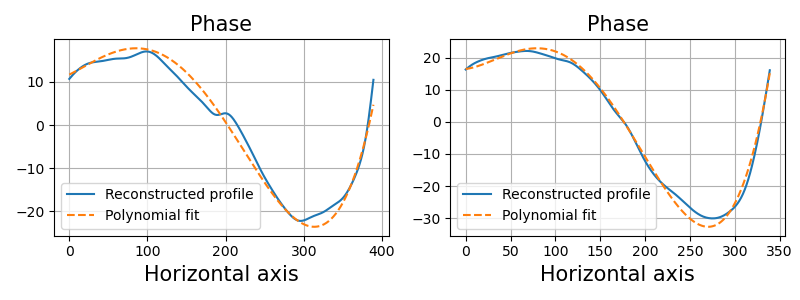

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(fit_obj_fs.pixels, fit_obj_fs.phase, label='Reconstructed profile')
axes[0].plot(fit_obj_fs.pixels, fit_obj_fs.model(fit_fs['ph_fit']), linestyle='dashed',
             label='Polynomial fit')
axes[0].set_xlabel('Horizontal axis', fontsize=15)
axes[1].plot(fit_obj_ss.pixels, fit_obj_ss.phase, label='Reconstructed profile')
axes[1].plot(fit_obj_ss.pixels, fit_obj_ss.model(fit_ss['ph_fit']), linestyle='dashed',
             label='Polynomial fit')
axes[1].set_xlabel('Horizontal axis', fontsize=15)
for ax in axes:
    ax.set_title('Phase', fontsize=15)
    ax.tick_params(labelsize=10)
    ax.legend(loc='lower left', fontsize=10)
    ax.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/phase_fit.png', dpi=300)

In [37]:
data.save(mode='overwrite')

In [38]:
!h5ls -r results/exp/diatom_proc.cxi

/                        Group
/entry                   Group
/entry/data              Group
/entry/data/data         Dataset {120/Inf, 340, 390}
/entry/instrument        Group
/entry/instrument/detector Group
/entry/instrument/detector/distance Dataset {SCALAR}
/entry/instrument/detector/x_pixel_size Dataset {SCALAR}
/entry/instrument/detector/y_pixel_size Dataset {SCALAR}
/entry/instrument/source Group
/entry/instrument/source/wavelength Dataset {SCALAR}
/speckle_tracking        Group
/speckle_tracking/basis_vectors Dataset {120/Inf, 2, 3}
/speckle_tracking/defocus_x Dataset {SCALAR}
/speckle_tracking/defocus_y Dataset {SCALAR}
/speckle_tracking/mask   Dataset {120/Inf, 340, 390}
/speckle_tracking/phase  Dataset {340, 390}
/speckle_tracking/pixel_aberrations Dataset {2, 340, 390}
/speckle_tracking/pixel_translations Dataset {120/Inf, 2}
/speckle_tracking/reference_image Dataset {1442, 1475}
/speckle_tracking/scale_map Dataset {340, 390}
/speckle_tracking/translations Dataset {120/Inf

# Generating a speckle tracking dataset

In [3]:
params = st_sim.STParams.import_default(bar_size=0.7, bar_sigma=0.12, bar_atn=0.18,
                                        bulk_atn=0.2, p0=5e4, th_s=8e-5, n_frames=100,
                                        offset=2.0, step_size=0.1, defocus=150, alpha=0.05,
                                        ab_cnt=0.7, bar_rnd=0.8)

In [4]:
protocol = rst.CXIProtocol.import_default()

In [5]:
sim_obj = st_sim.STSim(params)
ptych = sim_obj.ptychograph()
st_conv = st_sim.STConverter(sim_obj, ptych)
st_conv.save('results/sim.cxi', mode='overwrite')

In [6]:
!h5ls -r results/sim.cxi

/                        Group
/entry                   Group
/entry/data              Group
/entry/data/data         Dataset {100/Inf, 1, 985}
/entry/instrument        Group
/entry/instrument/detector Group
/entry/instrument/detector/distance Dataset {SCALAR}
/entry/instrument/detector/x_pixel_size Dataset {SCALAR}
/entry/instrument/detector/y_pixel_size Dataset {SCALAR}
/entry/instrument/source Group
/entry/instrument/source/wavelength Dataset {SCALAR}
/speckle_tracking        Group
/speckle_tracking/basis_vectors Dataset {100/Inf, 2, 3}
/speckle_tracking/defocus_x Dataset {SCALAR}
/speckle_tracking/defocus_y Dataset {SCALAR}
/speckle_tracking/mask   Dataset {100/Inf, 1, 985}
/speckle_tracking/pixel_translations Dataset {100/Inf, 2}
/speckle_tracking/translations Dataset {100/Inf, 3}
/speckle_tracking/whitefield Dataset {1, 985}


In [7]:
sim_obj = st_sim.STSim(params)
ptych = sim_obj.ptychograph()
st_conv = st_sim.STConverter(sim_obj, ptych)
data = st_conv.export_data('results/sim.cxi')

In [8]:
%%bash
source /software/anaconda3/5.2/bin/activate pyrost
python -m pyrost.simulation --help

usage: __main__.py [-h] [-f INI_FILE] [--defocus DEFOCUS]
                   [--det_dist DET_DIST] [--step_size STEP_SIZE]
                   [--step_rnd STEP_RND] [--n_frames N_FRAMES]
                   [--detx_size DETX_SIZE] [--dety_size DETY_SIZE] [--p0 P0]
                   [--wl WL] [--th_s TH_S] [--ap_x AP_X] [--ap_y AP_Y]
                   [--focus FOCUS] [--alpha ALPHA] [--ab_cnt AB_CNT]
                   [--bar_size BAR_SIZE] [--bar_sigma BAR_SIGMA]
                   [--bar_atn BAR_ATN] [--bulk_atn BULK_ATN]
                   [--bar_rnd BAR_RND] [--offset OFFSET] [-p]
                   out_path

Run Speckle Tracking simulation

positional arguments:
  out_path              Output folder path

optional arguments:
  -h, --help            show this help message and exit
  -f INI_FILE, --ini_file INI_FILE
                        Path to an INI file to fetch all of the simulation
                        parameters (default: None)
  --defocus DEFOCUS     Lens defocus distanc

In [9]:
%%bash
source /software/anaconda3/5.2/bin/activate pyrost
python -m pyrost.simulation results/sim.cxi --bar_size 0.7 --bar_sigma 0.12 \
    --bar_atn 0.18 --bulk_atn 0.2 --p0 5e4 --th_s 8e-5 --n_frames 200 --offset 2 \
    --step_size 0.1 --defocus 150 --alpha 0.05 --ab_cnt 0.7 --bar_rnd 0.8 -p

The simulation results have been saved to /gpfs/cfel/user/nivanov/speckle-tracking/pyrost/results/sim.cxi


In [10]:
!h5ls -r results/sim.cxi

/                        Group
/entry                   Group
/entry/data              Group
/entry/data/data         Dataset {200/Inf, 1, 985}
/entry/instrument        Group
/entry/instrument/detector Group
/entry/instrument/detector/distance Dataset {SCALAR}
/entry/instrument/detector/x_pixel_size Dataset {SCALAR}
/entry/instrument/detector/y_pixel_size Dataset {SCALAR}
/entry/instrument/source Group
/entry/instrument/source/wavelength Dataset {SCALAR}
/speckle_tracking        Group
/speckle_tracking/basis_vectors Dataset {200/Inf, 2, 3}
/speckle_tracking/defocus_x Dataset {SCALAR}
/speckle_tracking/defocus_y Dataset {SCALAR}
/speckle_tracking/mask   Dataset {200/Inf, 1, 985}
/speckle_tracking/pixel_translations Dataset {200/Inf, 2}
/speckle_tracking/translations Dataset {200/Inf, 3}
/speckle_tracking/whitefield Dataset {1, 985}


# Speckle tracking reconstruction of a simulated dataset

In [20]:
protocol = rst.CXIProtocol.import_default()
inp_file = rst.CXIStore('results/sim.cxi', protocol=protocol)
out_file = rst.CXIStore('results/sim.cxi', mode='a', protocol=protocol)
data = rst.STData(input_file=inp_file, output_file=out_file)
data = data.load()

Loading data:   0%|          | 0/200 [00:00<?, ?it/s]

Loading mask:   0%|          | 0/200 [00:00<?, ?it/s]

In [21]:
data.contents()

['defocus_y',
 'defocus_x',
 'wavelength',
 'mask',
 'basis_vectors',
 'translations',
 'output_file',
 'frames',
 'good_frames',
 'reference_image',
 'data',
 'num_threads',
 'phase',
 'y_pixel_size',
 'input_file',
 'pixel_translations',
 'whitefield',
 'pixel_aberrations',
 'x_pixel_size',
 'distance',
 'scale_map']

In [12]:
st_obj = data.get_st()
h0 = st_obj.find_hopt()
st_res = st_obj.train_adapt(search_window=(0.0, 10.0, 0.1), h0=h0, blur=8.0)

   0%            Iteration 0 / 30 [00:00<?, ?it/s]

Initial error = 12.388873, Initial h0 = 10.35


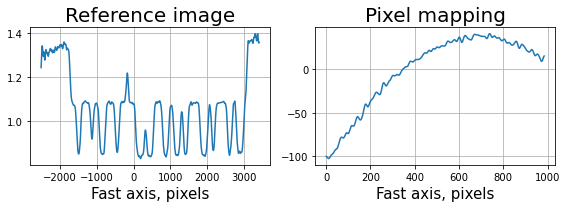

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(np.arange(st_res.reference_image.shape[1]) - st_res.ref_orig[1],
             st_res.reference_image[0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot((st_res.pixel_map - st_obj.pixel_map)[1, 0])
axes[1].set_title('Pixel mapping', fontsize=20)
for ax in axes:
    ax.tick_params(labelsize=10)
    ax.set_xlabel('Fast axis, pixels', fontsize=15)
    ax.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/1d_sim_res.png', dpi=300)

In [14]:
data.import_st(st_res)

In [15]:
fit_obj = data.get_fit(axis=1, center=20)
fit_obj = fit_obj.remove_linear_term()
fit = fit_obj.fit(max_order=2)
print(fit['c_3'])

-0.047284672322582856


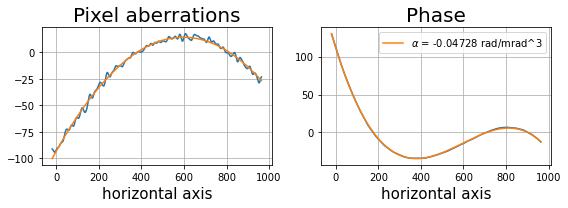

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(fit_obj.pixels, fit_obj.pixel_aberrations)
axes[0].plot(fit_obj.pixels, fit_obj.model(fit['fit']))
axes[0].set_title('Pixel aberrations', fontsize=20)
axes[1].plot(fit_obj.pixels, fit_obj.phase)
axes[1].plot(fit_obj.pixels, fit_obj.model(fit['ph_fit']),
             label=r'$\alpha$ = {:.5f} rad/mrad^3'.format(fit['c_3']))
axes[1].set_title('Phase', fontsize=20)
axes[1].legend(fontsize=10)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel('horizontal axis', fontsize=15)
    ax.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/1d_sim_fits.png', dpi=300)

In [17]:
data.save(mode='overwrite')

In [18]:
! h5ls -r results/sim.cxi

/                        Group
/entry                   Group
/entry/data              Group
/entry/data/data         Dataset {200/Inf, 1, 985}
/entry/instrument        Group
/entry/instrument/detector Group
/entry/instrument/detector/distance Dataset {SCALAR}
/entry/instrument/detector/x_pixel_size Dataset {SCALAR}
/entry/instrument/detector/y_pixel_size Dataset {SCALAR}
/entry/instrument/source Group
/entry/instrument/source/wavelength Dataset {SCALAR}
/speckle_tracking        Group
/speckle_tracking/basis_vectors Dataset {200/Inf, 2, 3}
/speckle_tracking/defocus_x Dataset {SCALAR}
/speckle_tracking/defocus_y Dataset {SCALAR}
/speckle_tracking/mask   Dataset {200/Inf, 1, 985}
/speckle_tracking/phase  Dataset {1, 985}
/speckle_tracking/pixel_aberrations Dataset {2, 1, 985}
/speckle_tracking/pixel_translations Dataset {200/Inf, 2}
/speckle_tracking/reference_image Dataset {1, 5927}
/speckle_tracking/scale_map Dataset {1, 985}
/speckle_tracking/translations Dataset {200/Inf, 3}
/speckle

# Processing a wavefront metrology experiment

In [3]:
data = rst.cxi_converter_sigray(scan_num=2989, target='Mo', distance=2.0)

Loading data:   0%|          | 0/101 [00:00<?, ?it/s]

In [4]:
data.contents()

['wavelength',
 'mask',
 'basis_vectors',
 'translations',
 'frames',
 'good_frames',
 'data',
 'num_threads',
 'y_pixel_size',
 'input_file',
 'whitefield',
 'x_pixel_size',
 'distance']

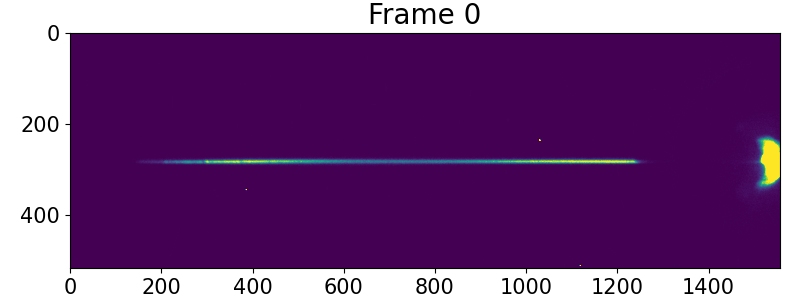

In [5]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 3))
ax.imshow(data.data[0], vmax=100)
ax.set_title('Frame 0', fontsize=20)
ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/sigray_frame.png', dpi=150)

In [6]:
crop = rst.Crop([270, 300, 200, 1240])
transform = rst.ComposeTransforms([crop, rst.Mirror(axis=1)])
data = data.update_transform(transform=transform)
data = data.update_mask(vmax=100000)

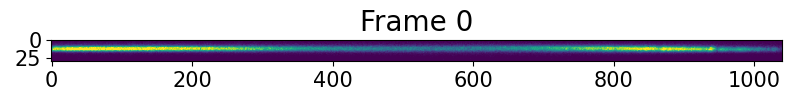

In [7]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 1))
ax.imshow(data.data[0], vmax=100)
ax.set_title('Frame 0', fontsize=20)
ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/sigray_crop.png', dpi=150)

In [8]:
data = data.integrate_data()

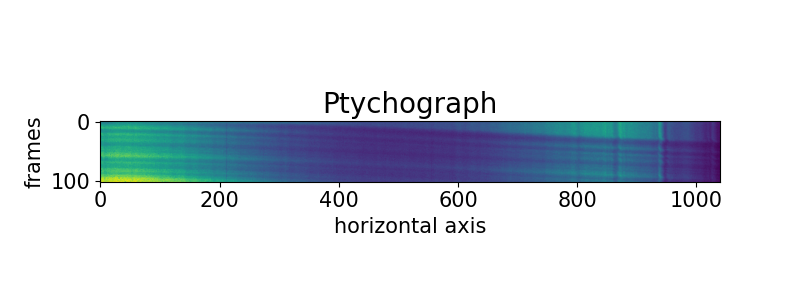

In [9]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 3))
ax.imshow(data.data[:, 0])
ax.set_title('Ptychograph', fontsize=20)
ax.set_xlabel('horizontal axis', fontsize=15)
ax.set_ylabel('frames', fontsize=15)
ax.tick_params(labelsize=15)
plt.show()
# plt.savefig('docs/figures/sigray_ptychograph.png', dpi=150)

In [10]:
defoci = np.linspace(50e-6, 300e-6, 50)
sweep_scan = data.defocus_sweep(defoci, size=50)
defocus = defoci[np.argmax(sweep_scan)]
print(defocus)

Generating defocus sweep:   0%|          | 0/50 [00:00<?, ?it/s]

0.00015204081632653058


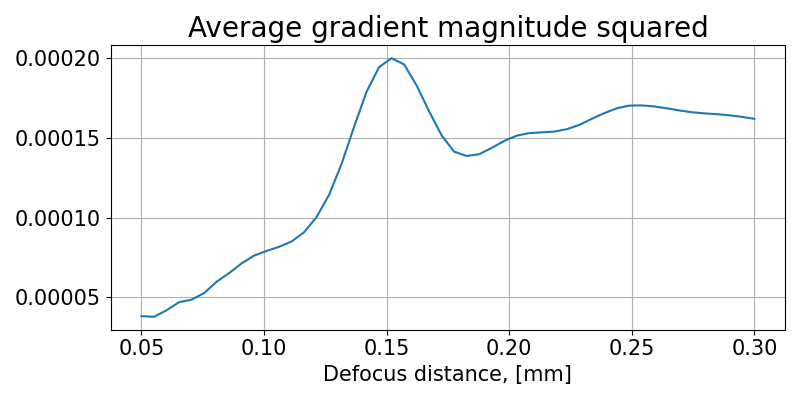

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(defoci * 1e3, sweep_scan)
ax.set_xlabel('Defocus distance, [mm]', fontsize=15)
ax.set_title('Average gradient magnitude squared', fontsize=20)
ax.tick_params(labelsize=15)
ax.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/sweep_scan_sigray.png', dpi=300)

In [12]:
data = data.update_defocus(defocus)

In [13]:
st_obj = data.get_st()
h0 = st_obj.find_hopt()
st_res = st_obj.train_adapt(search_window=(0.0, 10.0, 0.1), h0=h0, blur=8.0)

   0%            Iteration 0 / 30 [00:00<?, ?it/s]

Initial error = 52.310649, Initial h0 = 9.70


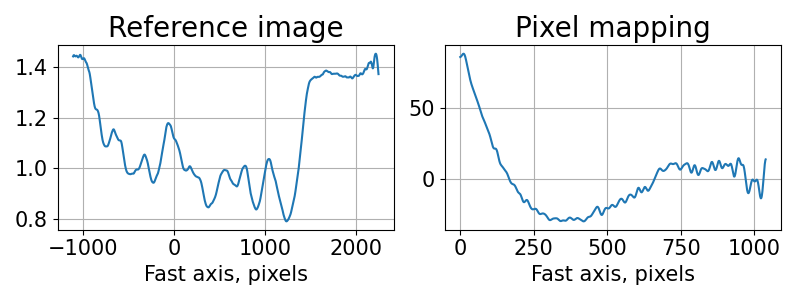

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(np.arange(st_res.reference_image.shape[1]) - st_res.ref_orig[1],
             st_res.reference_image[0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot((st_res.pixel_map - st_obj.pixel_map)[1, 0])
axes[1].set_title('Pixel mapping', fontsize=20)
for ax in axes:
    ax.tick_params(labelsize=15)
    ax.set_xlabel('Fast axis, pixels', fontsize=15)
    ax.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/sigray_res.png', dpi=300)

In [15]:
data.import_st(st_res)

In [16]:
fit_obj = data.get_fit(axis=1)
fit_obj = fit_obj.remove_linear_term()
fit = fit_obj.fit(max_order=3)

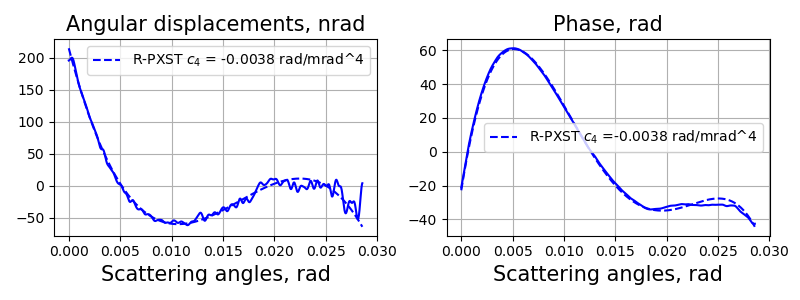

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(fit_obj.thetas, fit_obj.theta_ab * 1e9, 'b')
axes[0].plot(fit_obj.thetas, fit_obj.model(fit['fit']) * fit_obj.ref_ap * 1e9,
             'b--', label=fr"R-PXST $c_4$ = {fit['c_4']:.4f} rad/mrad^4")
axes[0].set_title('Angular displacements, nrad', fontsize=15)

axes[1].plot(fit_obj.thetas, fit_obj.phase, 'b')
axes[1].plot(fit_obj.thetas, fit_obj.model(fit['ph_fit']), 'b--',
             label=fr"R-PXST $c_4$ ={fit['c_4']:.4f} rad/mrad^4")
axes[1].set_title('Phase, rad', fontsize=15)
for ax in axes:
    ax.legend(fontsize=10)
    ax.tick_params(labelsize=10)
    ax.set_xlabel('Scattering angles, rad', fontsize=15)
    ax.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/sigray_fits.png', dpi=300)

In [19]:
out_file = rst.CXIStore('results/sigray.cxi', mode='a')
data = data.update_output_file(out_file)
data.save(mode='overwrite')